# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.364604
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$
Weights are randomly initialized hence uniform.
1/10 probability paritioning for each class, then
loss = -log(1/10) = log(10) = 2.3



In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
print("gradient regularization check")
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.176305 analytic: 2.176305, relative error: 1.761543e-08
numerical: -0.177533 analytic: -0.177533, relative error: 4.554767e-07


KeyboardInterrupt: 

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.364599e+00 computed in 32.426111s
vectorized loss: 2.364599e+00 computed in 0.084004s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 3e-7]
regularization_strengths = [2.5e4, 3.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_training = X_train.shape[0]

#divide training into folds
folds = []
folds_label = []
num_folds = 5
num_data_per_fold = num_training / num_folds

for i in range(num_folds):
    folds.append(X_train[int(i*num_data_per_fold):int((i+1)*num_data_per_fold),:])
    folds_label.append(y_train[int(i*num_data_per_fold):int((i+1)*num_data_per_fold)])
    
parameters = [ (l,r) for l in learning_rates for r in regularization_strengths ]

from functools import reduce

for (l,r) in parameters:
    
    accuracies = []
    
    print("l,r:", l,r)
    
    classifier_sm = Softmax()
    
    for i in range(num_folds):
        
        classifier_sm = Softmax()
        
        training_set = [folds[j] for j in range(num_folds) if j != i]
        training_label = [folds_label[j] for j in range(num_folds) if j != i]
        
        t_set = np.concatenate(training_set)
        t_label_set = np.concatenate(training_label)
        v_set = folds[i]
        v_label = folds_label[i]
        
        classifier_sm.train(t_set, t_label_set, l, r, num_iters=1500, verbose=True)
        
        pred_train = classifier_sm.predict(t_set)
        pred_validate = classifier_sm.predict(v_set)
        
        accuracy_train = np.mean(pred_train == t_label_set)
        accuracy_validation = np.mean(pred_validate == v_label)
        
        accuracies.append((accuracy_train,accuracy_validation))

    print(accuracies)

    accuracy = reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]), accuracies, (0,0))
    
    f = 1.0/len(accuracies)

    results[l,r] = (accuracy[0]*f, accuracy[1]*f)
    if accuracy[1]*f > best_val:
        best_softmax = classifier_sm
    best_val = max(best_val,accuracy[1]*f)
    print('validation accuracy: %f' % (accuracy[1]*f))    

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

l,r: 1e-07 25000.0
iteration 0 / 1500: loss 767.269389
iteration 100 / 1500: loss 281.325097
iteration 200 / 1500: loss 104.303464
iteration 300 / 1500: loss 39.520891
iteration 400 / 1500: loss 15.690025
iteration 500 / 1500: loss 7.103176
iteration 600 / 1500: loss 3.864405
iteration 700 / 1500: loss 2.785862
iteration 800 / 1500: loss 2.301653
iteration 900 / 1500: loss 2.138629
iteration 1000 / 1500: loss 2.100193
iteration 1100 / 1500: loss 2.083275
iteration 1200 / 1500: loss 2.082566
iteration 1300 / 1500: loss 2.104491
iteration 1400 / 1500: loss 2.080492
iteration 0 / 1500: loss 781.994759
iteration 100 / 1500: loss 286.965102
iteration 200 / 1500: loss 106.350002
iteration 300 / 1500: loss 40.224470
iteration 400 / 1500: loss 15.996663
iteration 500 / 1500: loss 7.230168
iteration 600 / 1500: loss 3.897565
iteration 700 / 1500: loss 2.796705
iteration 800 / 1500: loss 2.377315
iteration 900 / 1500: loss 2.144059
iteration 1000 / 1500: loss 2.133248
iteration 1100 / 1500: loss

iteration 1400 / 1500: loss 2.119886
iteration 0 / 1500: loss 1554.432540
iteration 100 / 1500: loss 209.478560
iteration 200 / 1500: loss 29.815760
iteration 300 / 1500: loss 5.868269
iteration 400 / 1500: loss 2.652462
iteration 500 / 1500: loss 2.248784
iteration 600 / 1500: loss 2.121433
iteration 700 / 1500: loss 2.150659
iteration 800 / 1500: loss 2.122467
iteration 900 / 1500: loss 2.144143
iteration 1000 / 1500: loss 2.147677
iteration 1100 / 1500: loss 2.209240
iteration 1200 / 1500: loss 2.148120
iteration 1300 / 1500: loss 2.124666
iteration 1400 / 1500: loss 2.165387
[(0.30558673469387754, 0.3062244897959184), (0.3142091836734694, 0.298265306122449), (0.3050765306122449, 0.3137755102040816), (0.3077295918367347, 0.3066326530612245), (0.30196428571428574, 0.29918367346938773)]
validation accuracy: 0.304816
l,r: 5e-07 25000.0
iteration 0 / 1500: loss 777.967794
iteration 100 / 1500: loss 6.917416
iteration 200 / 1500: loss 2.112842
iteration 300 / 1500: loss 2.119916
iteratio

iteration 800 / 1500: loss 2.167016
iteration 900 / 1500: loss 2.168746
iteration 1000 / 1500: loss 2.162821
iteration 1100 / 1500: loss 2.123857
iteration 1200 / 1500: loss 2.176642
iteration 1300 / 1500: loss 2.147909
iteration 1400 / 1500: loss 2.117126
iteration 0 / 1500: loss 1535.642338
iteration 100 / 1500: loss 2.225707
iteration 200 / 1500: loss 2.113363
iteration 300 / 1500: loss 2.154582
iteration 400 / 1500: loss 2.148832
iteration 500 / 1500: loss 2.152833
iteration 600 / 1500: loss 2.100314
iteration 700 / 1500: loss 2.147478
iteration 800 / 1500: loss 2.169570
iteration 900 / 1500: loss 2.137174
iteration 1000 / 1500: loss 2.125000
iteration 1100 / 1500: loss 2.114884
iteration 1200 / 1500: loss 2.164374
iteration 1300 / 1500: loss 2.135679
iteration 1400 / 1500: loss 2.127622
iteration 0 / 1500: loss 1529.778339
iteration 100 / 1500: loss 2.210718
iteration 200 / 1500: loss 2.181791
iteration 300 / 1500: loss 2.208864
iteration 400 / 1500: loss 2.181882
iteration 500 / 

iteration 200 / 1500: loss 2.135936
iteration 300 / 1500: loss 2.138616
iteration 400 / 1500: loss 2.143554
iteration 500 / 1500: loss 2.119138
iteration 600 / 1500: loss 2.112842
iteration 700 / 1500: loss 2.147769
iteration 800 / 1500: loss 2.167199
iteration 900 / 1500: loss 2.165265
iteration 1000 / 1500: loss 2.116583
iteration 1100 / 1500: loss 2.147084
iteration 1200 / 1500: loss 2.083232
iteration 1300 / 1500: loss 2.136461
iteration 1400 / 1500: loss 2.115959
iteration 0 / 1500: loss 1546.315291
iteration 100 / 1500: loss 5.609535
iteration 200 / 1500: loss 2.156543
iteration 300 / 1500: loss 2.159341
iteration 400 / 1500: loss 2.124564
iteration 500 / 1500: loss 2.125280
iteration 600 / 1500: loss 2.152792
iteration 700 / 1500: loss 2.171049
iteration 800 / 1500: loss 2.072351
iteration 900 / 1500: loss 2.119657
iteration 1000 / 1500: loss 2.144601
iteration 1100 / 1500: loss 2.143656
iteration 1200 / 1500: loss 2.176530
iteration 1300 / 1500: loss 2.128122
iteration 1400 / 1

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.340000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$
T

$\color{blue}{\textit Your Explanation:}$
The loss function involves fractional terms in which insertion of new samples would perturb numerator and denominator equally thus making the fractional term not equal to before


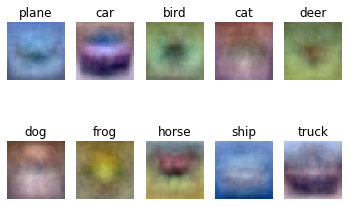

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])